
# UNHCR Forcibly Displaced Populations Casptone Project

## Decision Tree Classifier

---


In [9]:
import pandas as pd
import numpy as np
from pprint import pprint
import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.model_selection import GridSearchCV
from pactools.grid_search import GridSearchCVProgressBar
from sklearn.metrics import  plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report
from sklearn import preprocessing
import scikitplot as skplt
import warnings

In [11]:
warnings.filterwarnings('ignore')

In [12]:
import os
os.environ["PATH"] += os.pathsep + '~/opt/anaconda3/lib/python3.8/site-packages/graphviz/'

In [14]:
df = pd.read_csv('/Users/dayosangowawa/Desktop/GA/DSI20-lessons/projects/project-capstone/My Capstone/Forcibly displaced persons - Capstone Dayo Sangowawa/cleaned_unhcrdf_final.csv')
df.head()

,Unnamed: 0,country_of_origin,country_of_asylum,population_type,urban_or_rural_location,accommodation_type,female_aged_0-4 years,female_aged_5-11 years,female_aged_12-17 years,female_aged_18-59 years,female_aged_over_60_years,male_aged_0-4_years,male_aged_5-11_years,male_aged_12-17 years,male_aged_18-59_years,male_aged_over_60_years
0,0,Colombia,Aruba,ASY,Urban,I,0,0,0,0,0,0,0,0,5,0
1,1,Cuba,Aruba,ASY,Urban,I,0,0,0,0,0,0,0,0,0,0
2,2,Afghanistan,Afghanistan,IDP,Rural,I,0,14,16,37,0,0,15,17,38,5
3,3,Afghanistan,Afghanistan,IDP,Urban,Q,74,810,853,2004,140,75,840,921,2278,206
4,4,Afghanistan,Afghanistan,IDP,Urban,Q,12,130,138,321,21,12,135,147,365,33


In [15]:
df.drop(columns = ['Unnamed: 0'], inplace=True)

In [16]:
y = df.pop('accommodation_type')
X = pd.get_dummies(df, drop_first=True)

In [17]:
print('Baseline prediction: ', y.value_counts(normalize=True).max())

Baseline prediction:  0.8497186815375424


In [18]:
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y)

In [19]:
y
#'0 'if it is 'I 'and '1' if it is 'other'. 

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=1)

In [21]:
#decision trees we do not have to scale the values.

### GridSearch

In [23]:
DTC = DecisionTreeClassifier()

In [24]:
DTC_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 10),
    'max_features': [None],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.0001, 0.001, 0.005, 0.01]
}

DTC_gs = GridSearchCV(DTC, DTC_params, cv=5,
                      verbose=2, n_jobs=-1)

In [25]:
DTC_gs.fit(X_train, y_train)

Fitting 5 folds for each of 990 candidates, totalling 4950 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.0001, 0.001, 0.005, 0.01],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10), 'max_features': [None],
                         'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30,
                                               40, 50]},
             verbose=2)

In [26]:
DTC_best = DTC_gs.best_estimator_
print(DTC_gs.best_params_)
print(DTC_gs.best_score_)

{'ccp_alpha': 0.0001, 'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_samples_split': 2}
0.9396122466839094


In [28]:
DTC_best = DecisionTreeClassifier(criterion='gini',
                                    max_depth=9, 
                                    random_state=1,
                                    ccp_alpha =0.0001,
                                     max_features = None, 
                                     min_samples_split = 2)
DTC_best.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0001, max_depth=9, random_state=1)

In [29]:
print('Accuracy score - train set: ', DTC_best.score(X_train, y_train))
print('Accuracy score - test set: ', DTC_best.score(X_test, y_test))
mean_cv_scores_dtcbest = (cross_val_score(DTC_best, X_train, y_train, cv=5)).mean()
print('Mean CV score - train set: ', mean_cv_scores_dtcbest)

Accuracy score - train set:  0.9410904338084272
Accuracy score - test set:  0.940689569330346
Mean CV score - train set:  0.9396278060428639


In [30]:
feat_import = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': DTC_best.feature_importances_
})

feat_import.sort_values('Importance', ascending=False, inplace=True)
feat_import

,Feature,Importance
383,urban_or_rural_location_Urban,0.572537
234,country_of_asylum_Bulgaria,0.050054
277,country_of_asylum_Hungary,0.037226
248,country_of_asylum_Congo,0.028194
255,country_of_asylum_Democratic Republic of the C...,0.026878
...,...,...
129,country_of_origin_Morocco,0.000000
128,country_of_origin_Montenegro,0.000000
127,country_of_origin_Mongolia,0.000000
126,country_of_origin_Monaco,0.000000


In [31]:
feat_import.head(40)

,Feature,Importance
383,urban_or_rural_location_Urban,0.572537
234,country_of_asylum_Bulgaria,0.050054
277,country_of_asylum_Hungary,0.037226
248,country_of_asylum_Congo,0.028194
255,country_of_asylum_Democratic Republic of the C...,0.026878
280,country_of_asylum_Indonesia,0.026429
250,country_of_asylum_Croatia,0.026139
366,country_of_asylum_Uganda,0.025403
347,country_of_asylum_Slovenia,0.025345
382,population_type_RET,0.022241


In [32]:
feat_import.reset_index(inplace=True)

In [33]:
feat_import.drop(columns=['index'] ,inplace=True)

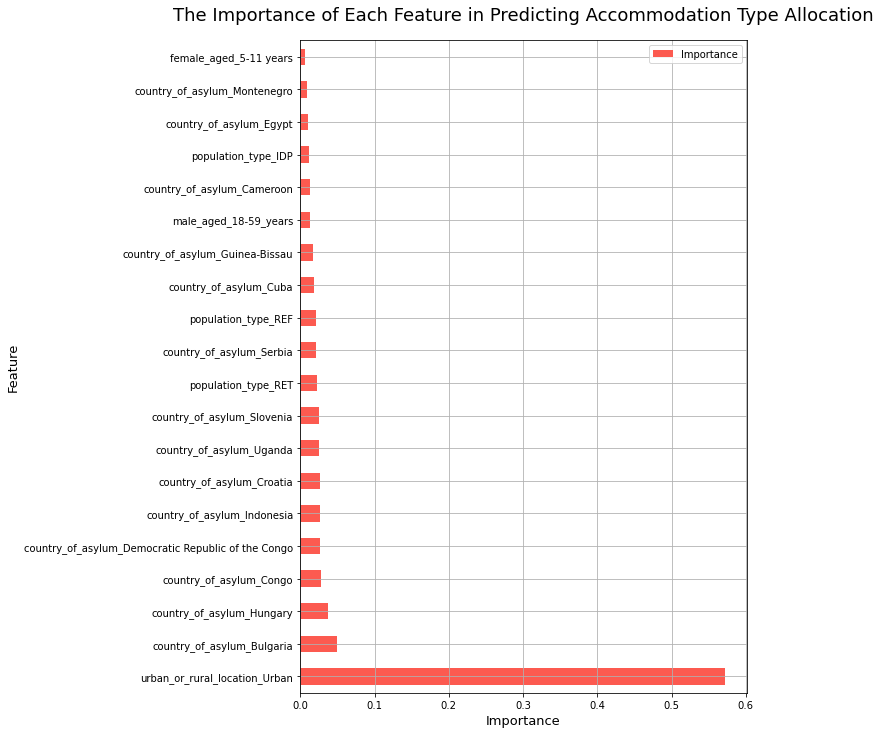

In [34]:
feat_import.nlargest(20, columns=['Importance']).plot(kind='barh', x='Feature', y='Importance', figsize=(8, 12), color='#FC5A50')
plt.xlabel('Importance', fontsize=13)
plt.ylabel('Feature', fontsize=13)
plt.title('The Importance of Each Feature in Predicting Accommodation Type Allocation', fontsize=18, pad=20)
plt.grid()
plt.show();

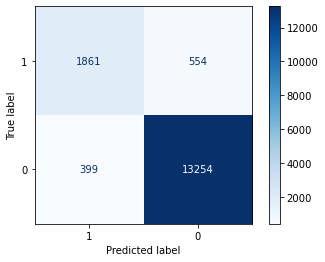

In [35]:
plot_confusion_matrix(DTC_best, X_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()

In [36]:
y_test_pred = DTC_best.predict(X_test)

In [37]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     13653
           1       0.82      0.77      0.80      2415

    accuracy                           0.94     16068
   macro avg       0.89      0.87      0.88     16068
weighted avg       0.94      0.94      0.94     16068



In [38]:
#classification report shows that f1s-score, recall score and precision scores are slightly better than using knn.

In [39]:
probabilities_train = DTC_best.predict_proba(X_train)

In [40]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", len(DTC_best.classes_)))

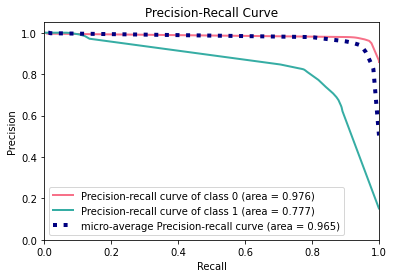

In [41]:
skplt.metrics.plot_precision_recall(y_train, probabilities_train, cmap=cmap)
plt.show()

In [42]:
print('Average precision score: ', average_precision_score(y_train, probabilities_train[:, 1]))

#quite a poor score. A better score would be closer to 1. 

Average precision score:  0.7765125638015938


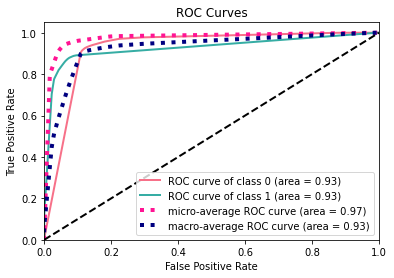

In [43]:
skplt.metrics.plot_roc(y_train, probabilities_train, cmap=cmap)
plt.show()

In [44]:
print('Area under the curve : ', roc_auc_score(y_train, probabilities_train[:, 1]))

Area under the curve :  0.9260894539790785
